In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

#with proper dass dataset 8 class, 5 round, total code


ModuleNotFoundError: No module named 'torch'

In [ ]:
data = pd.read_csv("dass_dataset.csv")

data.columns = ["text", "label"]

# Sample 500 rows while keeping class distribution
data_sampled = data.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=5000/len(data), random_state=42))

# Ensure exactly 500 rows (rounding issues may cause minor deviations)
data_sampled = data_sampled.sample(n=5000, random_state=42)

#data_sampled = data


<ipython-input-4-3398277d8a50>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sampled = data.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=5000/len(data), random_state=42))


In [ ]:
data_sampled['label'].value_counts(normalize=True)*100

,proportion
label,
0,28.64
1,24.34
2,15.86
3,15.84
4,5.72
5,4.14
6,3.86
7,1.60


In [ ]:
# 1. Data Loading and Splitting

##data = pd.read_csv("dass_dataset.csv")
#data = data.drop(data.columns[0], axis=1)
#data.columns = ["text", "label"]

# Sample 500 rows while keeping class distribution
#data_sampled = data.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=500/len(data), random_state=42))

# Ensure exactly 500 rows (rounding issues may cause minor deviations)
#data_sampled = data_sampled.sample(n=500, random_state=42)

# Split into train (80%) and test (20%)
train_data, test_data = train_test_split(
    data_sampled,
    test_size=0.2,
    random_state=42,
    stratify=data_sampled["label"]
)
#train_data, test_data = train_test_split(
    ##data,
    #test_size=0.2,
    #random_state=42,
    #stratify=data["label"]
#)
# Save the datasets
train_data.to_csv("train_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

print(f"Train dataset: {len(train_data)} rows, Test dataset: {len(test_data)} rows")


Train dataset: 4000 rows, Test dataset: 1000 rows


In [ ]:
# 2. Tokenization

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess(dataframe):
    tokenized = tokenizer(
        list(dataframe["text"]),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = dataframe["label"].values
    return tokenized, labels

train_tokens, train_labels = preprocess(train_data)
test_tokens, test_labels = preprocess(test_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# 3. Split the Training Data Among Clients

def split_clients(tokenized_data, labels, num_clients):
    client_data = []
    total_samples = len(tokenized_data["input_ids"])
    split_size = total_samples // num_clients

    for i in range(num_clients):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < (num_clients - 1) else total_samples

        input_ids = tokenized_data["input_ids"][start_idx:end_idx]
        attention_mask = tokenized_data["attention_mask"][start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]



        print(client_labels.dtype)  # Check the dtype
        print(client_labels)  # Check sample values

        client_labels = torch.tensor(client_labels, dtype=torch.long)

        client_data.append(((input_ids, attention_mask), client_labels))

    return client_data

num_clients = 3
clients = split_clients(train_tokens, train_labels, num_clients)


int64
[2 0 0 ... 0 0 1]
int64
[0 0 1 ... 0 1 5]
int64
[6 2 3 ... 0 0 0]


In [ ]:
# 4. Define Local Training

def train_local_model(client_data, model, epochs=8, batch_size=16):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    print(f"Using device: {device}")


    (input_ids, attention_mask), labels = client_data

    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = AdamW(model.parameters(), lr=5e-5)

    for epoch in range(epochs):
        for batch in dataloader:
            input_ids_b, attention_mask_b, labels_b = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(input_ids_b, attention_mask=attention_mask_b)
            loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels_b)
            loss.backward()
            optimizer.step()


In [ ]:
# 5. Federated Averaging

def federated_averaging(global_model, client_models):

    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack(
            [client.state_dict()[key] for client in client_models], dim=0
        ).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

In [ ]:
# 6. Evaluation Function

def evaluate_model(model, tokenized_data, labels, batch_size=16):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    #device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataset = TensorDataset(
        tokenized_data["input_ids"],
        tokenized_data["attention_mask"],
        torch.tensor(labels, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids_b, attention_mask_b, labels_b = [t.to(device) for t in batch]
            outputs = model(input_ids_b, attention_mask=attention_mask_b)
            logits = outputs.logits
            y_pred = torch.argmax(logits, dim=-1)
            preds.extend(y_pred.cpu().numpy())
            true_labels.extend(labels_b.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="weighted")
    report = classification_report(true_labels, preds)
    return acc, f1, report


In [ ]:
def print_model_params(model, label="Model Parameters"):
    classifier_means = {}
    for name, param in model.state_dict().items():
        if "classifier" in name:  # Only include classifier layers
            classifier_means[name] = param.mean().item()

    print(f"{label} - Classifier Layer Summary:")
    for layer, mean in classifier_means.items():
        print(f"{layer}: Mean = {mean:.6f}")


In [ ]:
global_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=8)
client_models = [
    RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=8)
    for _ in range(num_clients)
]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN th

In [ ]:
print_model_params(global_model, "Global Model")

Global Model - Classifier Layer Summary:
classifier.dense.weight: Mean = -0.000010
classifier.dense.bias: Mean = 0.000000
classifier.out_proj.weight: Mean = -0.000314
classifier.out_proj.bias: Mean = 0.000000


In [ ]:
def print_client_params(client_model, client_id):
    classifier_means = {}

    # Track only classifier layers
    for name, param in client_model.state_dict().items():
        if "classifier" in name:  # Only include classifier layers
            classifier_means[name] = param.mean().item()

    print(f"Client {client_id} Classifier Layer Summary:")
    for layer, mean in classifier_means.items():
        print(f"{layer}: Mean = {mean:.6f}")


In [ ]:
for client_model in client_models:
    print_client_params(client_model, client_models.index(client_model))

Client 0 Classifier Layer Summary:
classifier.dense.weight: Mean = -0.000050
classifier.dense.bias: Mean = 0.000000
classifier.out_proj.weight: Mean = 0.000134
classifier.out_proj.bias: Mean = 0.000000
Client 1 Classifier Layer Summary:
classifier.dense.weight: Mean = 0.000008
classifier.dense.bias: Mean = 0.000000
classifier.out_proj.weight: Mean = 0.000060
classifier.out_proj.bias: Mean = 0.000000
Client 2 Classifier Layer Summary:
classifier.dense.weight: Mean = -0.000045
classifier.dense.bias: Mean = 0.000000
classifier.out_proj.weight: Mean = -0.000217
classifier.out_proj.bias: Mean = 0.000000


In [ ]:
# 7. Federated Training Loop


num_rounds = 5

for round_num in range(num_rounds):
    print(f"Round {round_num+1}/{num_rounds}")



    # train client
    for client_id, client_data in enumerate(clients):
        train_local_model(client_data, client_models[client_id])

    for client_model in client_models:
      print_client_params(client_model, client_models.index(client_model))




    # Federated averaging with type correction
    for global_param, *local_params in zip(global_model.parameters(), *[model.parameters() for model in client_models]):
        avg_param = torch.stack([param.float() for param in local_params]).mean(dim=0)
        global_param.data.copy_(avg_param)

    print_model_params(global_model, "Global Model")


    acc, f1, report = evaluate_model(global_model, test_tokens, test_labels)
    print(f"  [Global Eval] Accuracy: {acc:.4f} | F1 (weighted): {f1:.4f}")
    final_acc, final_f1, final_report = evaluate_model(global_model, test_tokens, test_labels)
    print("\nFinal Evaluation on Test Set")
    print(f"Accuracy: {final_acc:.4f}")
    print(f"F1 (weighted): {final_f1:.4f}")
    print("Classification Report:")
    print(final_report)


    # Update client models with global model parameters
    for client_model in client_models:
        client_model.load_state_dict(global_model.state_dict())
    for client_model in client_models:
      print_client_params(client_model, client_models.index(client_model))




Round 1/5
Using device: cuda
Using device: cuda
Using device: cuda
Client 0 Classifier Layer Summary:
classifier.dense.weight: Mean = -0.000049
classifier.dense.bias: Mean = 0.000016
classifier.out_proj.weight: Mean = 0.000158
classifier.out_proj.bias: Mean = -0.000339
Client 1 Classifier Layer Summary:
classifier.dense.weight: Mean = 0.000007
classifier.dense.bias: Mean = -0.000013
classifier.out_proj.weight: Mean = 0.000057
classifier.out_proj.bias: Mean = -0.000343
Client 2 Classifier Layer Summary:
classifier.dense.weight: Mean = -0.000042
classifier.dense.bias: Mean = 0.000003
classifier.out_proj.weight: Mean = -0.000223
classifier.out_proj.bias: Mean = -0.000334
Global Model - Classifier Layer Summary:
classifier.dense.weight: Mean = -0.000028
classifier.dense.bias: Mean = 0.000002
classifier.out_proj.weight: Mean = -0.000003
classifier.out_proj.bias: Mean = -0.000339
  [Global Eval] Accuracy: 0.7770 | F1 (weighted): 0.7703

Final Evaluation on Test Set
Accuracy: 0.7770
F1 (weigh

In [ ]:
# 8. Final Evaluation on Test Set

final_acc, final_f1, final_report = evaluate_model(global_model, test_tokens, test_labels)
print("\nFinal Evaluation on Test Set")
print(f"Accuracy: {final_acc:.4f}")
print(f"F1 (weighted): {final_f1:.4f}")
print("Classification Report:")
print(final_report)



Final Evaluation on Test Set
Accuracy: 0.8090
F1 (weighted): 0.8098
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       287
           1       0.96      0.90      0.93       243
           2       0.62      0.60      0.61       159
           3       0.95      1.00      0.98       158
           4       0.78      0.88      0.83        57
           5       0.74      0.78      0.76        41
           6       0.50      0.62      0.55        39
           7       0.62      0.81      0.70        16

    accuracy                           0.81      1000
   macro avg       0.75      0.79      0.77      1000
weighted avg       0.81      0.81      0.81      1000



In [ ]:
# 8. Final Evaluation on Test Set

final_acc, final_f1, final_report = evaluate_model(global_model, test_tokens, test_labels)
print("\nFinal Evaluation on Test Set")
print(f"Accuracy: {final_acc:.4f}")
print(f"F1 (weighted): {final_f1:.4f}")
print("Classification Report:")
print(final_report)



Final Evaluation on Test Set
Accuracy: 0.8090
F1 (weighted): 0.8098
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       287
           1       0.96      0.90      0.93       243
           2       0.62      0.60      0.61       159
           3       0.95      1.00      0.98       158
           4       0.78      0.88      0.83        57
           5       0.74      0.78      0.76        41
           6       0.50      0.62      0.55        39
           7       0.62      0.81      0.70        16

    accuracy                           0.81      1000
   macro avg       0.75      0.79      0.77      1000
weighted avg       0.81      0.81      0.81      1000



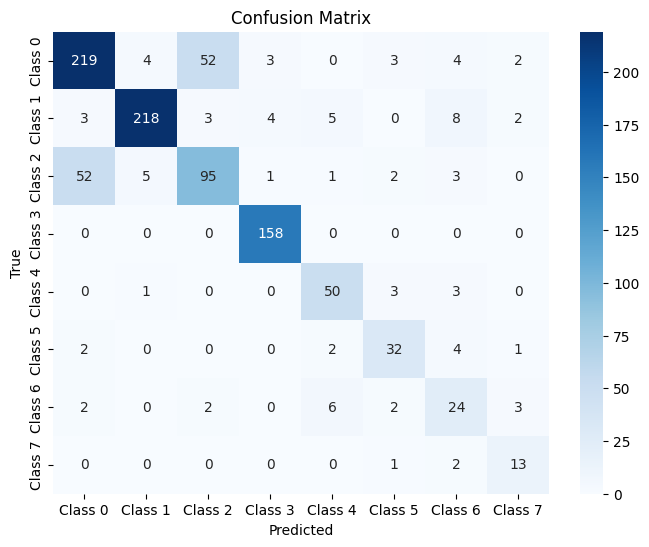

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, tokenized_data, labels, class_names):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataset = TensorDataset(
        tokenized_data["input_ids"],
        tokenized_data["attention_mask"],
        torch.tensor(labels, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids_b, attention_mask_b, labels_b = [t.to(device) for t in batch]
            outputs = model(input_ids_b, attention_mask=attention_mask_b)
            logits = outputs.logits
            y_pred = torch.argmax(logits, dim=-1)
            preds.extend(y_pred.cpu().numpy())
            true_labels.extend(labels_b.cpu().numpy())

    cm = confusion_matrix(true_labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5","Class 6", "Class 7"]

plot_confusion_matrix(global_model, test_tokens, test_labels, class_names)


Here is the Raw confusion matrix

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def manual_confusion_matrix(model, tokenized_data, labels):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataset = TensorDataset(
        tokenized_data["input_ids"],
        tokenized_data["attention_mask"],
        torch.tensor(labels, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids_b, attention_mask_b, labels_b = [t.to(device) for t in batch]
            outputs = model(input_ids_b, attention_mask=attention_mask_b)
            logits = outputs.logits
            y_pred = torch.argmax(logits, dim=-1)
            preds.extend(y_pred.cpu().numpy())
            true_labels.extend(labels_b.cpu().numpy())

    num_classes = len(set(true_labels).union(set(preds)))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(true_labels, preds):
        confusion_matrix[true][pred] += 1

    return confusion_matrix

raw_cm = manual_confusion_matrix(global_model, test_tokens, test_labels)
print("Raw Confusion Matrix:")
print(raw_cm)


Raw Confusion Matrix:
[[219   4  52   3   0   3   4   2]
 [  3 218   3   4   5   0   8   2]
 [ 52   5  95   1   1   2   3   0]
 [  0   0   0 158   0   0   0   0]
 [  0   1   0   0  50   3   3   0]
 [  2   0   0   0   2  32   4   1]
 [  2   0   2   0   6   2  24   3]
 [  0   0   0   0   0   1   2  13]]


In [ ]:
pip install joblib


In [ ]:
import joblib

joblib.dump(global_model, 'model_filename.pkl')




['model_filename.pkl']

In [ ]:
from google.colab import files

files.download('model_filename.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

joblib.dump(global_model, 'model_try_1.pkl')

['model_try_1.pkl']

In [ ]:
from google.colab import files

files.download('model_try_1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>